# Data Cleaning and Processing
This notebook performs cleaning and shortening of tweet data about bahlil and Raja Ampat mining activities.

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [2]:
# Load the data
df = pd.read_csv('palestina.csv')

In [3]:
# Initial data inspection
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset shape: (609, 15)

First few rows:


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1971706067492262191,Fri Sep 26 22:38:53 +0000 2025,6,Presiden Kolombia Gustavo Petro mengumumkan di...,1971706067492262191,NaN,NaN,in,NaN,0,0,2,https://x.com/undefined/status/197170606749226...,1250486881,NaN
1,1971705944028729549,Fri Sep 26 22:38:24 +0000 2025,0,@Menlu_RI Sugiono dari New York ; Pendudukan h...,1971705944028729549,NaN,Menlu_RI,in,NaN,0,0,0,https://x.com/undefined/status/197170594402872...,86012022,NaN
2,1971704208920662517,Fri Sep 26 22:37:47 +0000 2025,2,@SoftWarNews Ide prabowo baik. Ini rencana tak...,1971705789103682005,NaN,SoftWarNews,in,NaN,0,1,0,https://x.com/undefined/status/197170578910368...,1637974851750359040,NaN
3,1971399323729658125,Fri Sep 26 22:37:09 +0000 2025,0,@AndiPrasep59608 @detikcom Tdk ada data dan fa...,1971705632186421437,NaN,AndiPrasep59608,in,NaN,0,1,0,https://x.com/undefined/status/197170563218642...,1956988493080772608,NaN
4,1971036427032068541,Fri Sep 26 22:35:11 +0000 2025,0,@gincumirrah @MangAddang Presiden @prabowo lag...,1971705137443074164,NaN,gincumirrah,in,NaN,0,0,0,https://x.com/undefined/status/197170513744307...,2462313205,NaN


# Pembersihan Data

In [4]:
# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [5]:
# Clean text data
def clean_text(text):
    if pd.isna(text):
        return text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    text = text.replace('&amp;', 'dan')
    return text.lower()
df['cleaned_text'] = df['full_text'].apply(clean_text)

In [6]:
# Extract hashtags
def extract_hashtags(text):
    if pd.isna(text):
        return []
    return re.findall(r'#(\w+)', text)
df['hashtags'] = df['full_text'].apply(extract_hashtags)

In [7]:
# Handle missing values
df['in_reply_to_screen_name'].fillna('', inplace=True)
df['location'].fillna('', inplace=True)
df['image_url'].fillna('', inplace=True)

/tmp/ipython-input-3931258595.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['in_reply_to_screen_name'].fillna('', inplace=True)
/tmp/ipython-input-3931258595.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

# Data Shortening and Filtering

In [8]:
# Filter for relevant columns
columns_to_keep = ['created_at', 'username', 'cleaned_text', 'hashtags',
                   'favorite_count', 'retweet_count', 'reply_count', 'quote_count',
                   'image_url', 'location', 'lang', 'tweet_url']
df_clean = df[columns_to_keep]

In [9]:
# Remove duplicate tweets (based on cleaned text)
df_clean = df_clean.drop_duplicates(subset=['cleaned_text'])

In [10]:
# Filter for tweets that mention key terms
keywords = ['palestina', 'free palestina', 'muslim', 'islam', ]
def contains_keywords(text):
    if pd.isna(text):
        return False
    return any(keyword in text for keyword in keywords)
df_filtered = df_clean[df_clean['cleaned_text'].apply(contains_keywords)]

In [11]:
# Sort by engagement (favorites + retweets)
df_filtered['engagement'] = df_filtered['favorite_count'] + df_filtered['retweet_count']
df_sorted = df_filtered.sort_values('engagement', ascending=False)

/tmp/ipython-input-3447588314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['engagement'] = df_filtered['favorite_count'] + df_filtered['retweet_count']


# Analisis Sentimen (Basic)

In [12]:
import pandas as pd
from transformers import pipeline

# 1. Load model sentimen Bahasa Indonesia
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# 2. Pastikan df_sorted dan kolom 'cleaned_text' ada
try:
    if 'df_sorted' in locals() and 'cleaned_text' in df_sorted.columns:
        # 3. Terapkan analisis sentimen otomatis
        def get_sentiment(text):
            if pd.isna(text) or text.strip() == "":
                return 'neutral'
            result = classifier(text[:512])[0]  # max token limit
            return result['label'].lower()  # 'positive', 'negative', 'neutral'

        df_sorted['sentiment'] = df_sorted['cleaned_text'].apply(get_sentiment)
        print(df_sorted[['cleaned_text', 'sentiment']])
    else:
        print("df_sorted dataframe or 'cleaned_text' column not found. Please ensure previous steps ran successfully.")

except Exception as e:
    print(f"Terjadi error saat menjalankan model sentimen: {e}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


                                          cleaned_text sentiment
274  perdamaian palestina bisa terwujud jika semua ...  negative
581  jika saja sheikh ahmad yassin tidak mendirikan...  negative
198  hamas menanggapi pidato presiden otoritas pale...   neutral
567  sebelum 1948 israel itu tidak ada adanya negar...  negative
329  pa itu ga punya apa apa abbas mati pa bakal bu...  negative
..                                                 ...       ...
362  pidato panas prabowo di pbb bikin dunia heboh ...   neutral
204  mengusulkan kehadapan yang mulia presiden kira...   neutral
366  palestina ada dihati 6 milyard lebih penduduk ...  positive
231  saatnya bantuan persenjataan bagi rakyat pales...  negative
351  keren presiden prabowo nggak ragu suarain kead...  positive

[600 rows x 2 columns]


# Menyimpan Data Clean

In [13]:
# Save to new CSV
df_sorted.to_csv('cleaned_palestina_tweets.csv', index=False)
print(f"Final cleaned dataset shape: {df_sorted.shape}")
print("\nSample of cleaned data:")
df_sorted.head()

Final cleaned dataset shape: (600, 14)

Sample of cleaned data:


,created_at,username,cleaned_text,hashtags,favorite_count,retweet_count,reply_count,quote_count,image_url,location,lang,tweet_url,engagement,sentiment
274,2025-09-26 11:09:29+00:00,NaN,perdamaian palestina bisa terwujud jika semua ...,[],297,120,62,8,https://pbs.twimg.com/media/G1xKa9ybYAE4zq_.jpg,,in,https://x.com/undefined/status/197153257169272...,417,negative
581,2025-09-26 04:15:18+00:00,NaN,jika saja sheikh ahmad yassin tidak mendirikan...,[],251,98,4,1,,,in,https://x.com/undefined/status/197142833950950...,349,negative
198,2025-09-26 12:56:33+00:00,NaN,hamas menanggapi pidato presiden otoritas pale...,[],231,109,4,1,https://pbs.twimg.com/media/G1xi7VCaMAACBqf.jpg,,in,https://x.com/undefined/status/197155951632944...,340,neutral
567,2025-09-26 04:23:27+00:00,NaN,sebelum 1948 israel itu tidak ada adanya negar...,[],181,33,6,0,,,in,https://x.com/undefined/status/197143039331336...,214,negative
329,2025-09-26 09:54:37+00:00,NaN,pa itu ga punya apa apa abbas mati pa bakal bu...,[],98,38,6,3,,,in,https://x.com/undefined/status/197151373280011...,136,negative


#Hasil Analisis dan Visual

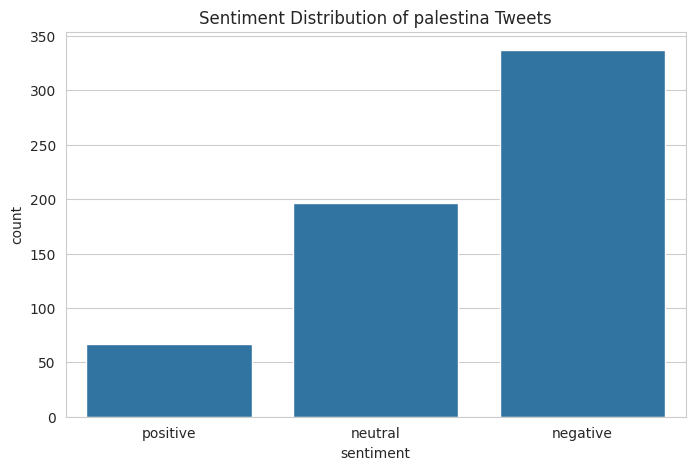

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sorted, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution of palestina Tweets')
plt.show()

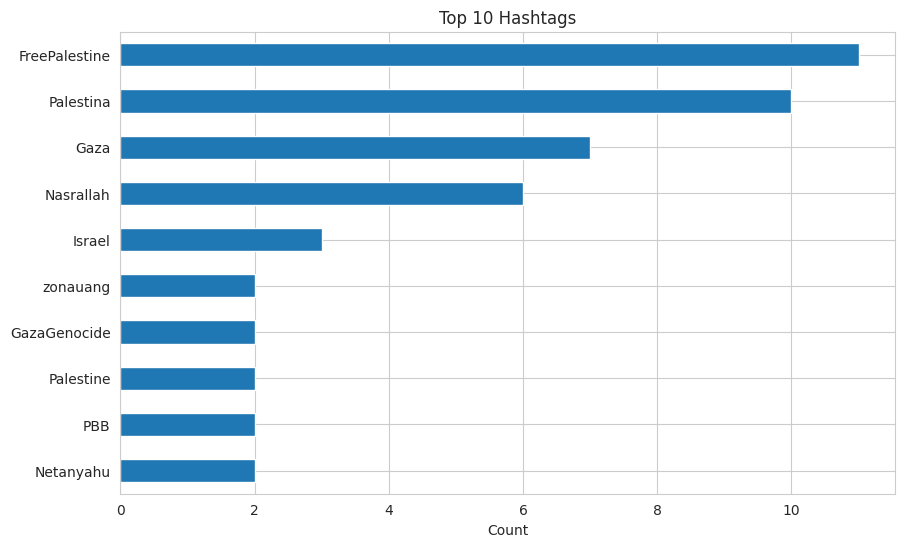

In [15]:
# Top hashtags
all_hashtags = [tag for sublist in df_sorted['hashtags'] for tag in sublist]
hashtag_counts = pd.Series(all_hashtags).value_counts().head(10)

# Check if hashtag_counts is empty before plotting
if not hashtag_counts.empty:
    plt.figure(figsize=(10, 6))
    hashtag_counts.plot(kind='barh')
    plt.title('Top 10 Hashtags')
    plt.xlabel('Count')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("No hashtags found to display the top 10.")

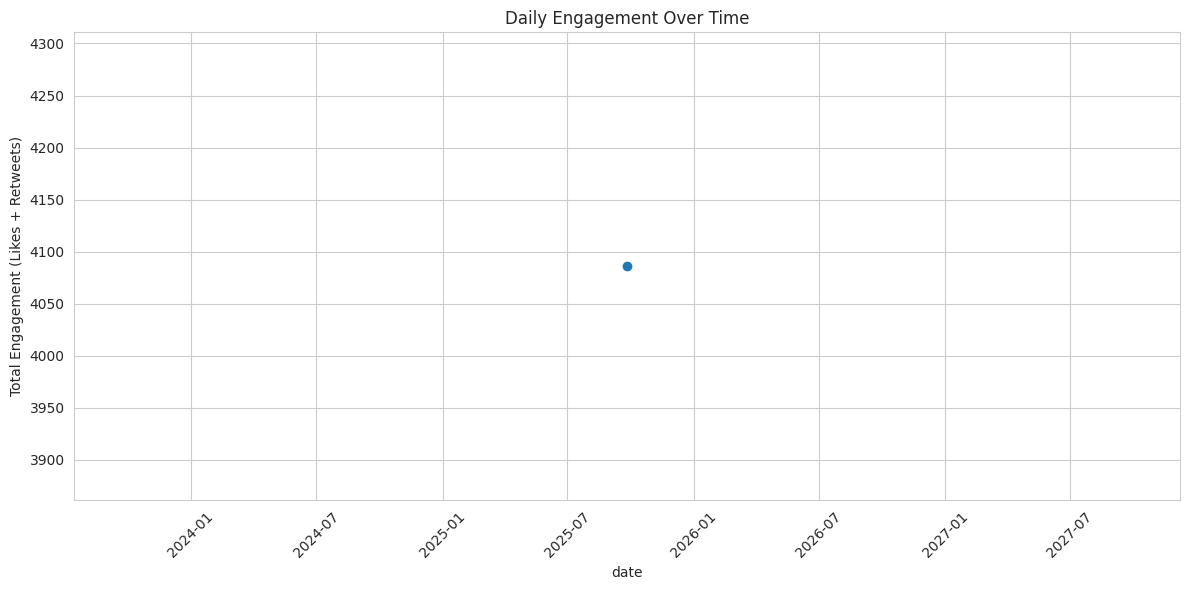

In [16]:
# Engagement over time
df_sorted['date'] = df_sorted['created_at'].dt.date
daily_engagement = df_sorted.groupby('date')['engagement'].sum()
plt.figure(figsize=(12, 6))
daily_engagement.plot(marker='o')
plt.title('Daily Engagement Over Time')
plt.ylabel('Total Engagement (Likes + Retweets)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


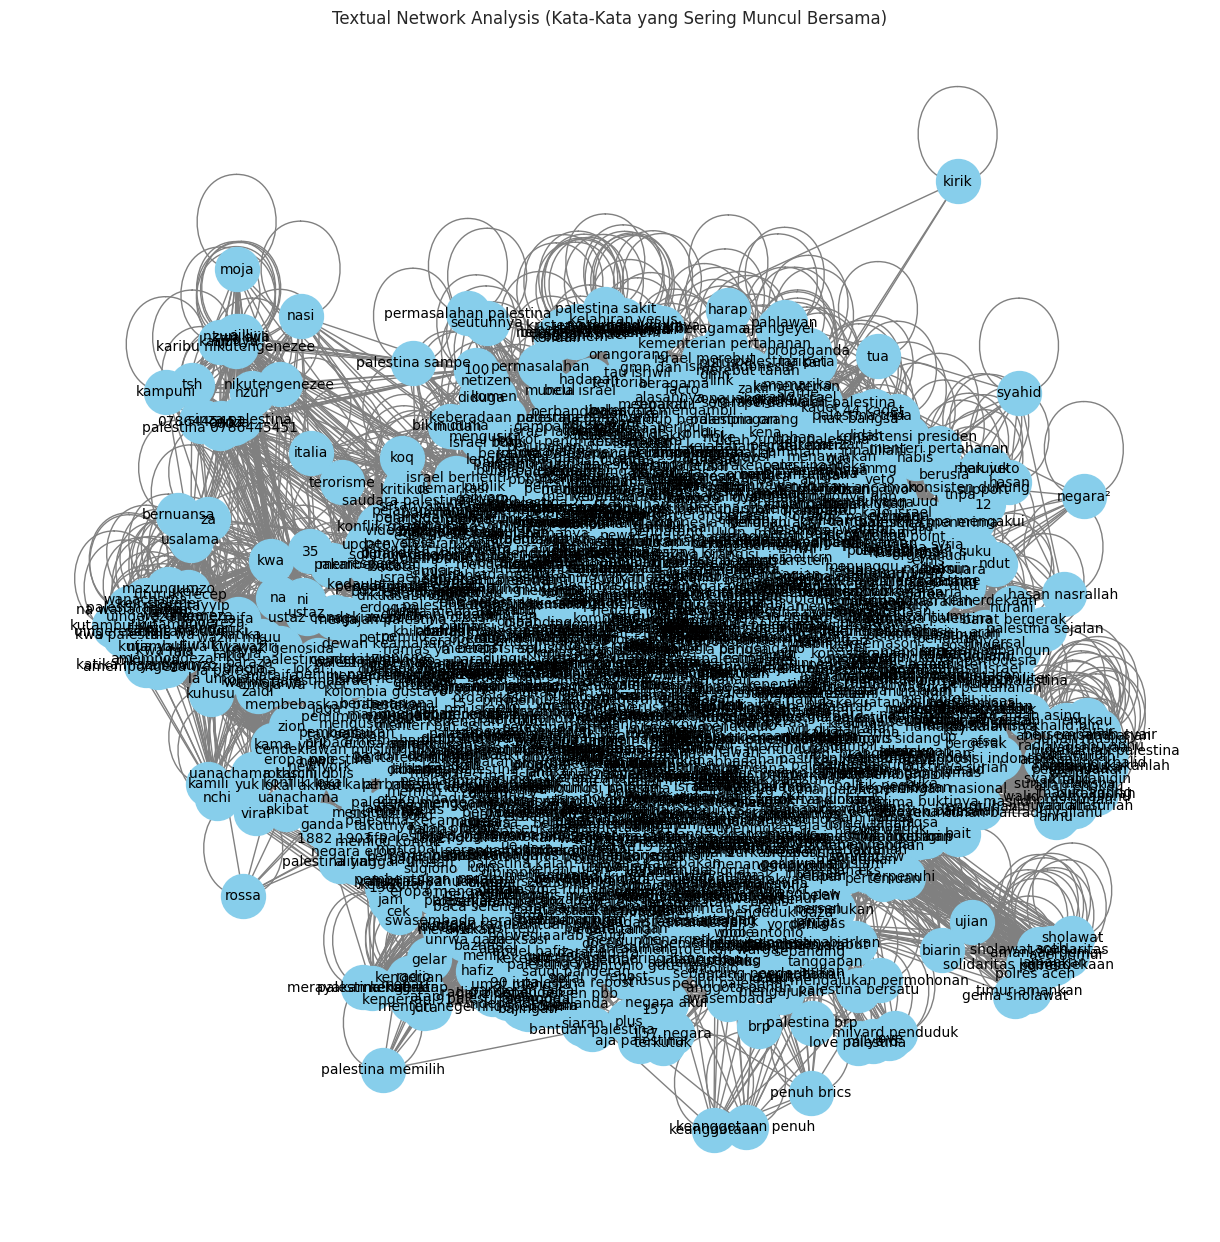

In [17]:
# Install required packages if necessary
!pip install --upgrade networkx scipy nltk scikit-learn

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Download stopwords Bahasa Indonesia
try:
    nltk.data.find('corpora/stopwords/indonesian')
except LookupError:
    nltk.download('stopwords')

# 1. Pastikan dataframe dan kolomnya tersedia
if 'df_sorted' in locals() and 'cleaned_text' in df_sorted.columns and not df_sorted['cleaned_text'].dropna().empty:
    texts = df_sorted['cleaned_text'].dropna().astype(str).tolist()

    # 2. Ambil stopwords Bahasa Indonesia
    indonesian_stop_words = stopwords.words('indonesian')

    # 3. Buat vectorizer n-gram 1 dan 2, min_df=2 supaya hanya yang sering muncul
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=indonesian_stop_words, min_df=2)
    X = vectorizer.fit_transform(texts)
    features = vectorizer.get_feature_names_out()

    if X.shape[0] > 0 and X.shape[1] > 0:
        # 4. Matriks co-occurrence
        co_occurrence_matrix = (X.T @ X)
        co_occurrence_matrix.setdiag(0)

        # 5. Buat graph (GANTI ke from_scipy_sparse_array)
        G = nx.from_scipy_sparse_array(co_occurrence_matrix)
        labels = {i: word for i, word in enumerate(features)}
        G = nx.relabel_nodes(G, labels)

        if G.number_of_nodes() > 0:
            plt.figure(figsize=(12, 12))
            pos = nx.spring_layout(G, k=0.3, seed=42)
            nx.draw(
                G, pos,
                with_labels=True,
                node_color='skyblue',
                edge_color='gray',
                node_size=1000,
                font_size=10
            )
            plt.title("Textual Network Analysis (Kata-Kata yang Sering Muncul Bersama)")
            plt.show()
        else:
            print("Graph kosong.")
    else:
        print("Tidak ada kata yang cukup sering muncul untuk divisualisasikan.")
else:
    print("Dataframe 'df_sorted' tidak ditemukan atau kolom 'cleaned_text' kosong.")
